In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import shutil
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.efficientnet import preprocess_input
import tensorflow.keras.layers as L


import shutil

print("Library berhasil diimpor.")

Library berhasil diimpor.


In [12]:

# ===============================================================
# PATH DIREKTORI (SESUAIKAN)
# ===============================================================
train_dir = "../Dataset/train"
test_dir = "../Dataset/test"
val_dir = "../Dataset/validation"
output_dir = "src"

# Ukuran gambar untuk EfficientNet
IMG_SIZE = (224, 224)




In [13]:

# ===============================================================
# MUAT MODEL TERBAIK
# ===============================================================
model_path = os.path.join(output_dir, "best_model.h5")


In [14]:

# ===============================================================
# SIAPKAN DATA TEST
# ===============================================================
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_flow = test_gen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=1,
    shuffle=False,
    class_mode='categorical'
)

# Nama kelas
class_names = list(test_flow.class_indices.keys())
print("Nama Kelas yang diurutkan:", class_names)


Found 0 images belonging to 0 classes.
Nama Kelas yang diurutkan: []


In [15]:
print("Jumlah kelas train:", len(os.listdir(train_dir)))
print("Jumlah kelas test:", len(os.listdir(test_dir)))
print("Jumlah kelas val:", len(os.listdir(val_dir)))

# -----------------------------
# Menghitung jumlah file per kelas
# -----------------------------
def hitung_file_per_kelas(directory):
    kelas = os.listdir(directory)
    for k in kelas:
        path_kelas = os.path.join(directory, k)
        if os.path.isdir(path_kelas):
            jumlah_file = len([
                f for f in os.listdir(path_kelas)
                if os.path.isfile(os.path.join(path_kelas, f))
            ])
            print(f"  - {k}: {jumlah_file} file")

print("\nDistribusi data train:")
hitung_file_per_kelas(train_dir)

print("\nDistribusi data test:")
hitung_file_per_kelas(test_dir)

print("\nDistribusi data validation:")
hitung_file_per_kelas(val_dir)

Jumlah kelas train: 4
Jumlah kelas test: 84
Jumlah kelas val: 4

Distribusi data train:
  - Tomato___Early_blight: 140 file
  - Tomato___healthy: 140 file
  - Tomato___Late_blight: 140 file
  - Tomato___Leaf_Mold: 140 file

Distribusi data test:

Distribusi data validation:
  - Tomato___Early_blight: 39 file
  - Tomato___healthy: 39 file
  - Tomato___Late_blight: 39 file
  - Tomato___Leaf_Mold: 39 file


In [16]:
# TF DATA PIPELINE
# ===============================================================
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
SEED = 42

# TRAIN SET (punya folder kelas)
train_ds = image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED
)

# TEST SET (TANPA folder kelas → labels=None)
test_ds = image_dataset_from_directory(
    test_dir,
    labels=None,
    label_mode=None,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

# VALIDATION SET (punya folder kelas)
val_ds = image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Class names:", class_names)


# DATA AUGMENTATION LAYERS
# ===============================================================
data_augmentation = tf.keras.Sequential([
    L.RandomFlip("horizontal"),
    L.RandomRotation(0.1),
    L.RandomZoom(0.12),
    L.RandomContrast(0.1)
])

print("tf.data Datasets dan Augmentasi disiapkan.")

Found 560 files belonging to 4 classes.
Found 84 files.
Found 156 files belonging to 4 classes.
Class names: ['Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___healthy']
tf.data Datasets dan Augmentasi disiapkan.


Found 560 files belonging to 4 classes.


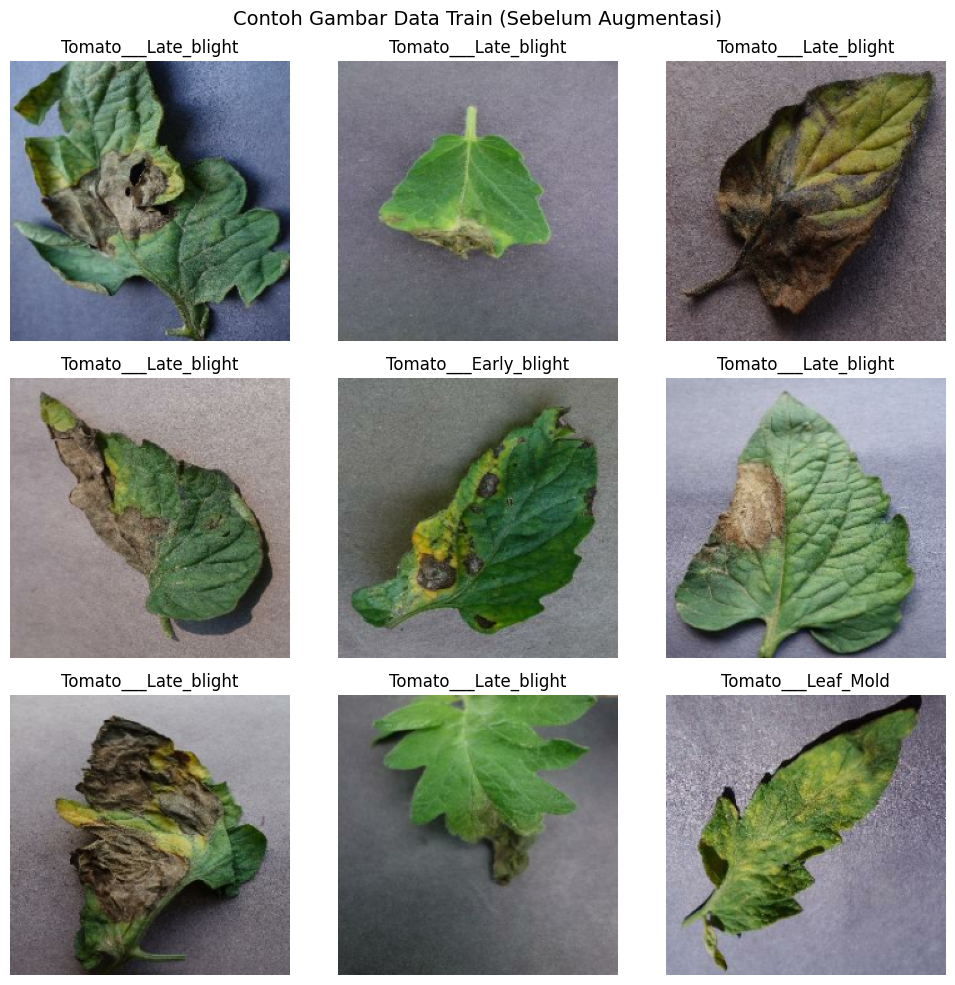

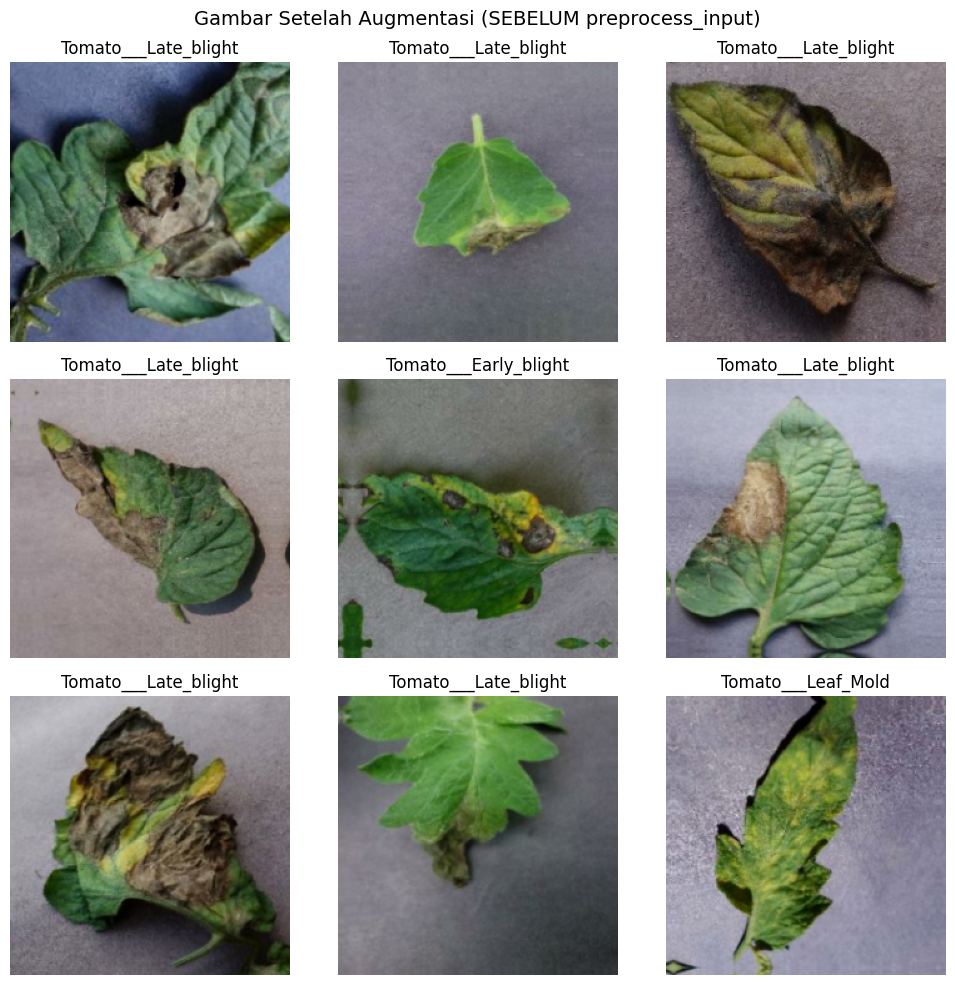

In [17]:
# Tampilkan sample gambar dari TRAIN (sebelum augmentasi)
# ============================

# Ambil batch pertama dari train dataset original (tanpa augmentasi)
raw_train = image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=9,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED
)

images, labels = next(iter(raw_train))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

plt.suptitle("Contoh Gambar Data Train (Sebelum Augmentasi)", fontsize=14)
plt.tight_layout()
plt.show()



# Terapkan augmentasi pada batch yang sama
augmented_images = data_augmentation(images, training=True)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # tf.cast(..., tf.uint8) diperlukan agar warna gambar benar
    plt.imshow(tf.cast(augmented_images[i], tf.uint8).numpy()) 
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

plt.suptitle("Gambar Setelah Augmentasi (SEBELUM preprocess_input)", fontsize=14)
plt.tight_layout()
plt.show()

In [18]:
import math 
AUTOTUNE = tf.data.AUTOTUNE

def prepare_for_training(ds, shuffle=True, augment=False):
    # Mapping untuk preprocessing (normalisasi spesifik EfficientNet)
    ds = ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
    if augment:
        # Mapping untuk augmentasi (hanya di train)
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(500, seed=SEED)
    # Cache dan Prefetch untuk optimasi
    return ds.cache().prefetch(AUTOTUNE)

def prepare_for_test(ds):
    # Mapping untuk preprocessing (hanya X)
    ds = ds.map(lambda x: preprocess_input(x), num_parallel_calls=AUTOTUNE)
    return ds.cache().prefetch(AUTOTUNE)


train_ds = prepare_for_training(train_ds, shuffle=True, augment=True)
val_ds = prepare_for_training(val_ds, shuffle=False)
test_ds = prepare_for_test(test_ds)

# Hitung jumlah batch dan data untuk verifikasi
total_files = 0
for folder in os.listdir(train_dir):
    total_files += len(os.listdir(os.path.join(train_dir, folder)))
total_batches = math.ceil(total_files / BATCH_SIZE)

print("Pipeline data (train, val, test) telah dioptimalkan.")
print(f"Total data train asli: {total_files}")
print(f"Total batch per epoch: {total_batches}")

Pipeline data (train, val, test) telah dioptimalkan.
Total data train asli: 560
Total batch per epoch: 9


In [19]:
# MODEL: EfficientNetB0 + Fine Tuning
# ===============================================================
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

base_model.trainable = False  # freeze awal

inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
# Catatan: Augmentasi dan preprocessing sudah ada di pipeline prepare_for_training
# Namun, karena kode asli Anda menyertakannya di sini, kita ikuti.
# x = data_augmentation(inputs) # Dihapus agar tidak terjadi augmentasi ganda
# x = preprocess_input(inputs) # Dihapus agar tidak terjadi preprocessing ganda

x = base_model(inputs, training=False) # training=False untuk base model
x = GlobalAveragePooling2D()(x)

x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# Tambah dense layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(
    optimizer=Adam(1e-4), # Learning Rate lebih tinggi untuk stage 1
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Arsitektur Model (Stage 1: Frozen Base) berhasil dibuat.")
model.summary()

Arsitektur Model (Stage 1: Frozen Base) berhasil dibuat.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,383,655 (16.72 MB)

 Trainable params: 331,524 (1.26 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [20]:
# CALLBACKS SATGE 1 
# ===============================================================
os.makedirs("src", exist_ok=True) # Pastikan folder output ada

callbacks_stage1 = [
    ModelCheckpoint(
        "src/best_stage1.h5",
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=6,
        restore_best_weights=True,
        verbose=1
    )
]


# TRAINING (STAGE 1 – Freezed Base Model)
# ===============================================================
EPOCHS = 100

print("🔧 Memulai Pelatihan Stage 1 (Frozen Base)...")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks_stage1
)

🔧 Memulai Pelatihan Stage 1 (Frozen Base)...
Epoch 1/100


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.2955 - loss: 2.4427
Epoch 1: val_accuracy improved from None to 0.50641, saving model to src/best_stage1.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.3321 - loss: 2.2177 - val_accuracy: 0.5064 - val_loss: 1.2710
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.4711 - loss: 1.5029
Epoch 2: val_accuracy improved from 0.50641 to 0.60256, saving model to src/best_stage1.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 937ms/step - accuracy: 0.4946 - loss: 1.4302 - val_accuracy: 0.6026 - val_loss: 1.1126
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.5698 - loss: 1.1877
Epoch 3: val_accuracy improved from 0.60256 to 0.64744, saving model to src/best_stage1.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 915ms/step - accuracy: 0.6018 - loss: 1.0706 - val_accuracy: 0.6474 - val_loss: 0.9931
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - accuracy: 0.6912 - loss: 0.8225
Epoch 4: val_accuracy improved from 0.64744 to 0.68590, saving model to src/best_stage1.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 961ms/step - accuracy: 0.6929 - loss: 0.8373 - val_accuracy: 0.6859 - val_loss: 0.9027
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.6998 - loss: 0.7542
Epoch 5: val_accuracy improved from 0.68590 to 0.71154, saving model to src/best_stage1.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 928ms/step - accuracy: 0.7196 - loss: 0.7305 - val_accuracy: 0.7115 - val_loss: 0.8303
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.8000 - loss: 0.5699
Epoch 6: val_accuracy improved from 0.71154 to 0.75641, saving model to src/best_stage1.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 925ms/step - accuracy: 0.8000 - loss: 0.5794 - val_accuracy: 0.7564 - val_loss: 0.7693
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.7963 - loss: 0.5141
Epoch 7: val_accuracy improved from 0.75641 to 0.78205, saving model to src/best_stage1.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 930ms/step - accuracy: 0.8018 - loss: 0.5350 - val_accuracy: 0.7821 - val_loss: 0.7202
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.8366 - loss: 0.4761
Epoch 8: val_accuracy improved from 0.78205 to 0.78846, saving model to src/best_stage1.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 921ms/step - accuracy: 0.8571 - loss: 0.4363 - val_accuracy: 0.7885 - val_loss: 0.6756
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.8231 - loss: 0.4259
Epoch 9: val_accuracy improved from 0.78846 to 0.80128, saving model to src/best_stage1.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 996ms/step - accuracy: 0.8411 - loss: 0.4154 - val_accuracy: 0.8013 - val_loss: 0.6356
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.8695 - loss: 0.3686
Epoch 10: val_accuracy improved from 0.80128 to 0.80769, saving model to src/best_stage1.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 950ms/step - accuracy: 0.8661 - loss: 0.3799 - val_accuracy: 0.8077 - val_loss: 0.5972
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 739ms/step - accuracy: 0.9032 - loss: 0.3045
Epoch 11: val_accuracy improved from 0.80769 to 0.84615, saving model to src/best_stage1.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8875 - loss: 0.3300 - val_accuracy: 0.8462 - val_loss: 0.5614
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.8681 - loss: 0.3489
Epoch 12: val_accuracy did not improve from 0.84615
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 941ms/step - accuracy: 0.8839 - loss: 0.3142 - val_accuracy: 0.8462 - val_loss: 0.5288
Epoch 13/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9212 - loss: 0.2382
Epoch 13: val_accuracy improved from 0.84615 to 0.85256, saving model to src/best_stage1.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 994ms/step - accuracy: 0.9036 - loss: 0.2485 - val_accuracy: 0.8526 - val_loss: 0.4986
Epoch 14/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.9166 - loss: 0.2383
Epoch 14: val_accuracy improved from 0.85256 to 0.87179, saving model to src/best_stage1.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 943ms/step - accuracy: 0.9179 - loss: 0.2413 - val_accuracy: 0.8718 - val_loss: 0.4705
Epoch 15/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.8939 - loss: 0.2703
Epoch 15: val_accuracy did not improve from 0.87179
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 942ms/step - accuracy: 0.8946 - loss: 0.2619 - val_accuracy: 0.8718 - val_loss: 0.4427
Epoch 16/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.9183 - loss: 0.2346
Epoch 16: val_accuracy did not improve from 0.87179
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 942ms/step - accuracy: 0.9268 - loss: 0.2166 - val_accuracy: 0.8654 - val_loss: 0.4185
Epoch 17/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.9136 - loss: 0.2718
Epoch 17: val_accuracy improved from 0.87179 to 0.87821, saving model to src/best_stage1.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 956ms/step - accuracy: 0.9286 - loss: 0.2260 - val_accuracy: 0.8782 - val_loss: 0.3973
Epoch 18/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/step - accuracy: 0.9265 - loss: 0.2274
Epoch 18: val_accuracy improved from 0.87821 to 0.89744, saving model to src/best_stage1.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9321 - loss: 0.2031 - val_accuracy: 0.8974 - val_loss: 0.3777
Epoch 19/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 739ms/step - accuracy: 0.9381 - loss: 0.1889
Epoch 19: val_accuracy improved from 0.89744 to 0.90385, saving model to src/best_stage1.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9393 - loss: 0.1822 - val_accuracy: 0.9038 - val_loss: 0.3611
Epoch 20/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.9339 - loss: 0.1855
Epoch 20: val_accuracy did not improve from 0.90385
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 939ms/step - accuracy: 0.9321 - loss: 0.1804 - val_accuracy: 0.9038 - val_loss: 0.3460
Epoch 21/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.9469 - loss: 0.1862
Epoch 21: val_accuracy did not improve from 0.90385
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 905ms/step - accuracy: 0.9518 - loss: 0.1774 - val_accuracy: 0.9038 - val_loss: 0.3304
Epoch 22/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.9319 - loss: 0.1719
Epoch 22: val_accuracy did not improve from 0.90385
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 907ms/step - accuracy: 0.9321 - loss: 0.1805 - val_accuracy: 0.9038 - val_loss: 0.3162
Epoch 23/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.9294 - loss: 0.1897
Epoch 23: val_accuracy improved from 0.9038

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 968ms/step - accuracy: 0.9339 - loss: 0.1720 - val_accuracy: 0.9103 - val_loss: 0.3031
Epoch 24/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.9351 - loss: 0.1591
Epoch 24: val_accuracy did not improve from 0.91026
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 893ms/step - accuracy: 0.9375 - loss: 0.1518 - val_accuracy: 0.9103 - val_loss: 0.2928
Epoch 25/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.9459 - loss: 0.1591
Epoch 25: val_accuracy did not improve from 0.91026
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 896ms/step - accuracy: 0.9571 - loss: 0.1442 - val_accuracy: 0.9103 - val_loss: 0.2837
Epoch 26/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.9555 - loss: 0.1328
Epoch 26: val_accuracy improved from 0.91026 to 0.92308, saving model to src/best_stage1.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 966ms/step - accuracy: 0.9536 - loss: 0.1400 - val_accuracy: 0.9231 - val_loss: 0.2716
Epoch 27/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 710ms/step - accuracy: 0.9678 - loss: 0.1172
Epoch 27: val_accuracy did not improve from 0.92308
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 931ms/step - accuracy: 0.9554 - loss: 0.1255 - val_accuracy: 0.9231 - val_loss: 0.2614
Epoch 28/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.9580 - loss: 0.1359
Epoch 28: val_accuracy did not improve from 0.92308
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 907ms/step - accuracy: 0.9518 - loss: 0.1305 - val_accuracy: 0.9231 - val_loss: 0.2529
Epoch 29/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.9725 - loss: 0.1028
Epoch 29: val_accuracy did not improve from 0.92308
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 901ms/step - accuracy: 0.9696 - loss: 0.1145 - val_accuracy: 0.9231 - val_loss: 0.2437
Epoch 30/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.9726 - loss: 0.1306
Epoch 30: val_accuracy did not improve f

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 942ms/step - accuracy: 0.9589 - loss: 0.1082 - val_accuracy: 0.9295 - val_loss: 0.2206
Epoch 33/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9660 - loss: 0.0938
Epoch 33: val_accuracy improved from 0.92949 to 0.93590, saving model to src/best_stage1.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 954ms/step - accuracy: 0.9661 - loss: 0.0943 - val_accuracy: 0.9359 - val_loss: 0.2150
Epoch 34/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.9567 - loss: 0.1147
Epoch 34: val_accuracy improved from 0.93590 to 0.94231, saving model to src/best_stage1.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 974ms/step - accuracy: 0.9554 - loss: 0.1087 - val_accuracy: 0.9423 - val_loss: 0.2084
Epoch 35/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.9751 - loss: 0.0968
Epoch 35: val_accuracy did not improve from 0.94231
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 885ms/step - accuracy: 0.9661 - loss: 0.0944 - val_accuracy: 0.9423 - val_loss: 0.2016
Epoch 36/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.9676 - loss: 0.1079
Epoch 36: val_accuracy did not improve from 0.94231
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 920ms/step - accuracy: 0.9643 - loss: 0.1106 - val_accuracy: 0.9423 - val_loss: 0.1951
Epoch 37/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.9774 - loss: 0.0832
Epoch 37: val_accuracy improved from 0.94231 to 0.94872, saving model to src/best_stage1.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 987ms/step - accuracy: 0.9786 - loss: 0.0749 - val_accuracy: 0.9487 - val_loss: 0.1896
Epoch 38/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - accuracy: 0.9645 - loss: 0.1013
Epoch 38: val_accuracy did not improve from 0.94872
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 934ms/step - accuracy: 0.9679 - loss: 0.0937 - val_accuracy: 0.9487 - val_loss: 0.1855
Epoch 39/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.9796 - loss: 0.0743
Epoch 39: val_accuracy did not improve from 0.94872
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 911ms/step - accuracy: 0.9768 - loss: 0.0860 - val_accuracy: 0.9487 - val_loss: 0.1805
Epoch 40/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.9814 - loss: 0.0683
Epoch 40: val_accuracy did not improve from 0.94872
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 912ms/step - accuracy: 0.9750 - loss: 0.0731 - val_accuracy: 0.9487 - val_loss: 0.1766
Epoch 41/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.9649 - loss: 0.0923
Epoch 41: val_accuracy did not improve f

In [21]:
# ===============================================================
# STAGE 2 — FINE-TUNING EfficientNet
# ===============================================================

import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os

print("\n==============================")
print(" STAGE 2 : FINE-TUNING MULAI")
print("==============================\n")

# Pastikan base_model sudah ada (EfficientNetB0 misalnya)
# base_model = model.layers[0]  <-- pastikan ini sesuai arsitektur Anda

if not isinstance(base_model, tf.keras.Model):
    raise ValueError("❌ ERROR: base_model tidak ditemukan. Pastikan Stage 1 sudah berjalan.")


# ===============================================================
# 1️⃣ UNFREEZE 30 LAYER TERAKHIR EfficientNet
# ===============================================================

# Hitung index untuk membuka 30 layer terakhir EfficientNet
fine_tune_at = len(base_model.layers) - 30

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False  # tetap freeze
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True   # buka 30 terakhir

print(f"🔓 Membuka {len(base_model.layers) - fine_tune_at} layer terakhir untuk fine-tuning.")
print("Total trainable layers:", np.sum([layer.trainable for layer in base_model.layers]))


# ===============================================================
# 2️⃣ CALLBACKS — Stage 2 (Fine-tuning)
# ===============================================================

callbacks_stage2 = [
    ModelCheckpoint(
        "src/best_model.h5",
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor="val_accuracy",
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]


# ===============================================================
# 3️⃣ COMPILE ULANG untuk Fine-tuning
# ===============================================================

model.compile(
    optimizer=Adam(learning_rate=1e-4),   # wajib kecil!
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("🚀 Model dikompilasi ulang untuk Stage 2 (fine-tuning).")


# ===============================================================
# 4️⃣ TRAINING — Stage 2
# ===============================================================

EPOCHS_FT = 30

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FT,
    callbacks=callbacks_stage2
)

print("\n🎉 Fine-tuning selesai!")
print("📌 Model terbaik disimpan di: src/best_model.h5")



 STAGE 2 : FINE-TUNING MULAI

🔓 Membuka 30 layer terakhir untuk fine-tuning.
Total trainable layers: 30
🚀 Model dikompilasi ulang untuk Stage 2 (fine-tuning).
Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.8453 - loss: 0.3922
Epoch 1: val_accuracy improved from None to 0.92949, saving model to src/best_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8536 - loss: 0.3775 - val_accuracy: 0.9295 - val_loss: 0.1986 - learning_rate: 1.0000e-04
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.9131 - loss: 0.2548
Epoch 2: val_accuracy did not improve from 0.92949
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9143 - loss: 0.2385 - val_accuracy: 0.9231 - val_loss: 0.1956 - learning_rate: 1.0000e-04
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step - accuracy: 0.9503 - loss: 0.1300
Epoch 3: val_accuracy did not improve from 0.92949
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9518 - loss: 0.1333 - val_accuracy: 0.9231 - val_loss: 0.1844 - learning_rate: 1.0000e-04
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - accuracy: 0.9627 - loss: 0.1179
Epoch 4: val_accuracy improved from 0.92949 to 0.94231, saving model to src/best_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9536 - loss: 0.1200 - val_accuracy: 0.9423 - val_loss: 0.1692 - learning_rate: 1.0000e-04
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.9702 - loss: 0.0878
Epoch 5: val_accuracy did not improve from 0.94231
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9607 - loss: 0.1225 - val_accuracy: 0.9359 - val_loss: 0.1597 - learning_rate: 1.0000e-04
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.9796 - loss: 0.0524
Epoch 6: val_accuracy did not improve from 0.94231
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9804 - loss: 0.0570 - val_accuracy: 0.9359 - val_loss: 0.1524 - learning_rate: 1.0000e-04
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 839ms/step - accuracy: 0.9879 - loss: 0.0535
Epoch 7: val_accuracy did not improve from 0.94231
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9857 - loss: 0.0543 - val_accuracy: 0.9359 - val_loss: 0.1461 - learning_rate: 1.0000e-04
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9946 - loss: 0.0270 - val_accuracy: 0.9487 - val_loss: 0.1203 - learning_rate: 1.0000e-04
Epoch 13/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 844ms/step - accuracy: 0.9910 - loss: 0.0294
Epoch 13: val_accuracy did not improve from 0.94872
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9929 - loss: 0.0230 - val_accuracy: 0.9487 - val_loss: 0.1189 - learning_rate: 1.0000e-04
Epoch 14/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.9923 - loss: 0.0201
Epoch 14: val_accuracy did not improve from 0.94872
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9911 - loss: 0.0219 - val_accuracy: 0.9423 - val_loss: 0.1189 - learning_rate: 1.0000e-04
Epoch 15/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 835ms/step - accuracy: 0.9993 - loss: 0.0210
Epoch 15: val_accuracy did not improve from 0.94872
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9982 - loss: 0.0251 - val_accuracy: 0.9423 - val_loss: 0.1189 - learning_rate: 1.0000e-04
Epoch 16/30
9/9 ━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 1.0000 - loss: 0.0105 - val_accuracy: 0.9551 - val_loss: 0.1075 - learning_rate: 1.0000e-04
Epoch 18/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 0.9865 - loss: 0.0328
Epoch 18: val_accuracy did not improve from 0.95513
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9893 - loss: 0.0290 - val_accuracy: 0.9551 - val_loss: 0.1031 - learning_rate: 1.0000e-04
Epoch 19/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 816ms/step - accuracy: 1.0000 - loss: 0.0094
Epoch 19: val_accuracy improved from 0.95513 to 0.96154, saving model to src/best_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 1.0000 - loss: 0.0112 - val_accuracy: 0.9615 - val_loss: 0.0985 - learning_rate: 1.0000e-04
Epoch 20/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 839ms/step - accuracy: 1.0000 - loss: 0.0081
Epoch 20: val_accuracy did not improve from 0.96154
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 1.0000 - loss: 0.0085 - val_accuracy: 0.9615 - val_loss: 0.0958 - learning_rate: 1.0000e-04
Epoch 21/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 1.0000 - loss: 0.0101
Epoch 21: val_accuracy did not improve from 0.96154
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 1.0000 - loss: 0.0099 - val_accuracy: 0.9615 - val_loss: 0.0945 - learning_rate: 1.0000e-04
Epoch 22/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.9977 - loss: 0.0115
Epoch 22: val_accuracy improved from 0.96154 to 0.96795, saving model to src/best_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9946 - loss: 0.0180 - val_accuracy: 0.9679 - val_loss: 0.0921 - learning_rate: 1.0000e-04
Epoch 23/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 871ms/step - accuracy: 0.9976 - loss: 0.0072
Epoch 23: val_accuracy improved from 0.96795 to 0.97436, saving model to src/best_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9982 - loss: 0.0082 - val_accuracy: 0.9744 - val_loss: 0.0894 - learning_rate: 1.0000e-04
Epoch 24/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 812ms/step - accuracy: 0.9976 - loss: 0.0058
Epoch 24: val_accuracy did not improve from 0.97436
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9982 - loss: 0.0061 - val_accuracy: 0.9551 - val_loss: 0.0900 - learning_rate: 1.0000e-04
Epoch 25/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 816ms/step - accuracy: 0.9948 - loss: 0.0090
Epoch 25: val_accuracy did not improve from 0.97436
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9982 - loss: 0.0061 - val_accuracy: 0.9551 - val_loss: 0.0906 - learning_rate: 1.0000e-04
Epoch 26/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - accuracy: 1.0000 - loss: 0.0074
Epoch 26: val_accuracy did not improve from 0.97436

Epoch 26: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 1.0000 - loss: 0.0066 - val_accuracy: 0.95

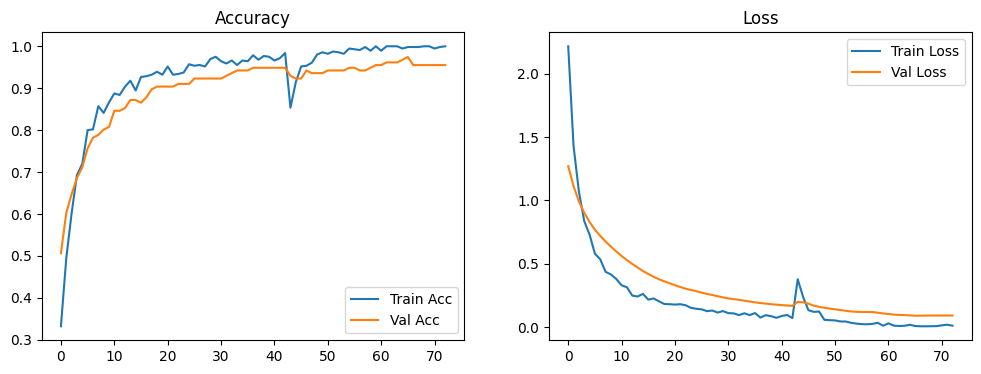

In [22]:
# PLOTTING
# ===============================================================
acc = history.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history.history['val_accuracy'] + history_finetune.history['val_accuracy']
loss = history.history['loss'] + history_finetune.history['loss']
val_loss = history.history['val_loss'] + history_finetune.history['val_loss']

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()

=== Metrics for Training Set ===


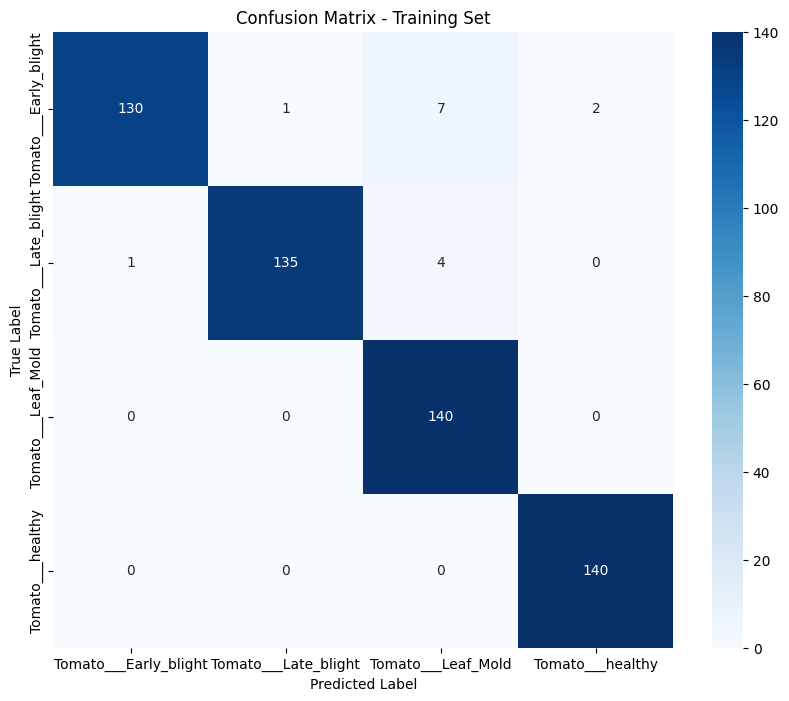

Classification Report - Training Set:
                       precision    recall  f1-score   support

Tomato___Early_blight       0.99      0.93      0.96       140
 Tomato___Late_blight       0.99      0.96      0.98       140
   Tomato___Leaf_Mold       0.93      1.00      0.96       140
     Tomato___healthy       0.99      1.00      0.99       140

             accuracy                           0.97       560
            macro avg       0.97      0.97      0.97       560
         weighted avg       0.97      0.97      0.97       560

Training Accuracy: 97.32%
=== Metrics for Validation Set ===


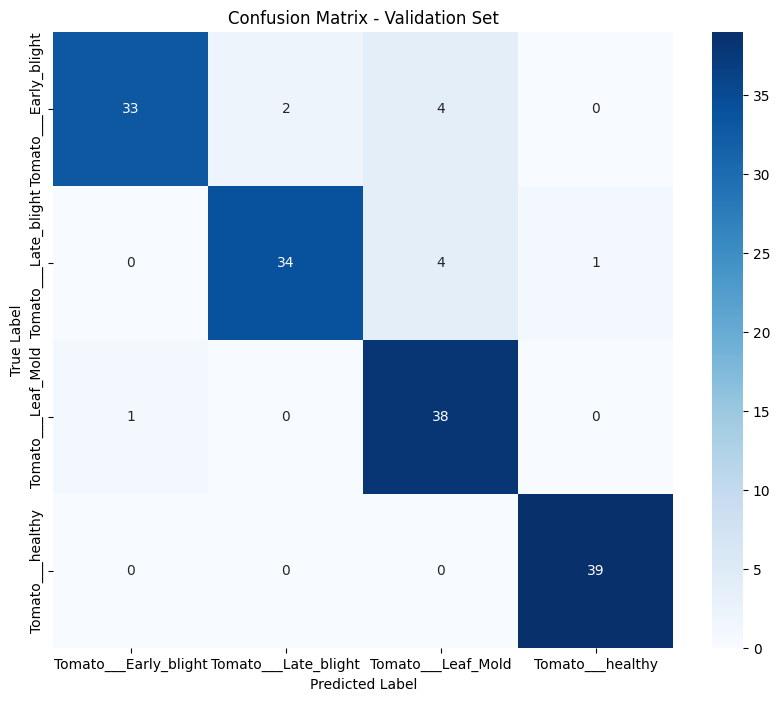

Classification Report - Validation Set:
                       precision    recall  f1-score   support

Tomato___Early_blight       0.97      0.85      0.90        39
 Tomato___Late_blight       0.94      0.87      0.91        39
   Tomato___Leaf_Mold       0.83      0.97      0.89        39
     Tomato___healthy       0.97      1.00      0.99        39

             accuracy                           0.92       156
            macro avg       0.93      0.92      0.92       156
         weighted avg       0.93      0.92      0.92       156

Validation Accuracy: 92.31%


In [23]:
#confusion matrix and classification report untuk data train dan val
# ===============================================================
# Load model terbaik dari pelatihan
best_model = tf.keras.models.load_model("src/best_model.h5")

# Pastikan variable class_names terisi. Jika kosong, coba ambil dari sumber lain.
if not class_names:
    # Coba ambil dari train_ds jika tersedia
    try:
        class_names = train_ds.class_names
    except Exception:
        # Coba dari test_flow jika tersedia (flow_from_directory)
        try:
            class_names = list(test_flow.class_indices.keys())
        except Exception:
            # Coba dari dictionary class_indices jika tersedia
            try:
                class_names = [k for k, v in sorted(class_indices.items(), key=lambda x: x[1])]
            except Exception:
                raise ValueError("class_names kosong dan tidak dapat ditentukan otomatis. Pastikan train_ds/test_flow/class_indices terdefinisi.")

# Fungsi untuk mendapatkan prediksi dan label asli dari dataset (dataset harus mengembalikan (x, y))
def get_predictions_and_labels(model, dataset):
    predictions = []
    labels = []
    for batch in dataset:
        imgs, lbls = batch
        preds = model.predict(imgs, verbose=0)
        predictions.extend(np.argmax(preds, axis=1))
        # lbls bisa berupa Tensor; gunakan numpy() lalu argmax
        labels.extend(np.argmax(lbls.numpy(), axis=1))
    return np.array(predictions), np.array(labels)

# Dapatkan prediksi dan label asli untuk data train
train_predictions, train_labels = get_predictions_and_labels(best_model, train_ds)
# Dapatkan prediksi dan label asli untuk data val
val_predictions, val_labels = get_predictions_and_labels(best_model, val_ds)

# Fungsi untuk menampilkan confusion matrix dan classification report
def display_metrics(true_labels, pred_labels, dataset_type):
    cm = confusion_matrix(true_labels, pred_labels)
    # Pastikan jumlah target_names sama dengan jumlah kelas
    if len(class_names) != len(np.unique(np.concatenate([true_labels, pred_labels]))):
        # Jika jumlah kelas yang muncul berbeda, gunakan labels agar raport bekerja
        labels = sorted(list(set(true_labels.tolist() + pred_labels.tolist())))
        cr = classification_report(true_labels, pred_labels, labels=labels, target_names=[class_names[i] for i in labels])
    else:
        cr = classification_report(true_labels, pred_labels, target_names=class_names)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {dataset_type} Set')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    print(f'Classification Report - {dataset_type} Set:\n{cr}')

# Tampilkan metrik untuk data train
print("=== Metrics for Training Set ===")
display_metrics(train_labels, train_predictions, "Training")
#tampilkna accuracy data train dalam persen
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(train_labels, train_predictions) * 100

print(f"Training Accuracy: {train_accuracy:.2f}%")


# Tampilkan metrik untuk data val
print("=== Metrics for Validation Set ===")
display_metrics(val_labels, val_predictions, "Validation")


#tampilkna accuracy data val dan test dalam persen 
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(train_labels, train_predictions) * 100
val_accuracy = accuracy_score(val_labels, val_predictions) * 100
print(f"Validation Accuracy: {val_accuracy:.2f}%")










In [24]:
# Prediksi
test_predictions = best_model.predict(test_ds)
predicted_classes = np.argmax(test_predictions, axis=1)
predicted_class_names = [class_names[i] for i in predicted_classes]

output_dir = "test_predictions"
os.makedirs(output_dir, exist_ok=True)

# HANYA tampilkan prediksi (tanpa filepaths)
for i in range(min(21, len(predicted_class_names))):
    print(f"Gambar {i+1}: Predicted Class - {predicted_class_names[i]}")

print("Prediksi pada data test selesai.")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step
Gambar 1: Predicted Class - Tomato___Early_blight
Gambar 2: Predicted Class - Tomato___Early_blight
Gambar 3: Predicted Class - Tomato___Early_blight
Gambar 4: Predicted Class - Tomato___healthy
Gambar 5: Predicted Class - Tomato___Early_blight
Gambar 6: Predicted Class - Tomato___Early_blight
Gambar 7: Predicted Class - Tomato___Late_blight
Gambar 8: Predicted Class - Tomato___Early_blight
Gambar 9: Predicted Class - Tomato___Early_blight
Gambar 10: Predicted Class - Tomato___Early_blight
Gambar 11: Predicted Class - Tomato___Early_blight
Gambar 12: Predicted Class - Tomato___Early_blight
Gambar 13: Predicted Class - Tomato___Early_blight
Gambar 14: Predicted Class - Tomato___Early_blight
Gambar 15: Predicted Class - Tomato___Early_blight
Gambar 16: Predicted Class - Tomato___Early_blight
Gambar 17: Predicted Class - Tomato___Early_blight
Gambar 18: Predicted Class - Tomato___Late_blight
Gambar 19: Predicted Class - Tomato___Early_blight
Gambar 2

In [25]:
import numpy as np
import pandas as pd

# Predict
test_predictions = best_model.predict(test_ds)
predicted_classes = np.argmax(test_predictions, axis=1)
predicted_class_names = [class_names[i] for i in predicted_classes]

# Distribusi prediksi
pred_counts = pd.Series(predicted_class_names).value_counts().reindex(class_names, fill_value=0)
print("Predicted counts per class:\n", pred_counts)

# Ground truth counts per class yang kamu sebut: mis. setiap kelas 21
ground_truth_counts = pd.Series([21]*len(class_names), index=class_names)

compare_df = pd.DataFrame({
    'ground_truth_count': ground_truth_counts,
    'predicted_count': pred_counts
})
compare_df['diff'] = compare_df['predicted_count'] - compare_df['ground_truth_count']
print(compare_df)

# Simpan prediksi lengkap dengan y_true


df = pd.DataFrame({'y_pred,': predicted_class_names})
df.to_csv('test_predictions_only_pred.csv', index=False)
print("Saved: test_predictions_only_pred.csv")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step
Predicted counts per class:
 Tomato___Early_blight    18
Tomato___Late_blight     19
Tomato___Leaf_Mold       24
Tomato___healthy         23
Name: count, dtype: int64
                       ground_truth_count  predicted_count  diff
Tomato___Early_blight                  21               18    -3
Tomato___Late_blight                   21               19    -2
Tomato___Leaf_Mold                     21               24     3
Tomato___healthy                       21               23     2
Saved: test_predictions_only_pred.csv


Panjang y_true = 84
Panjang y_pred = 84


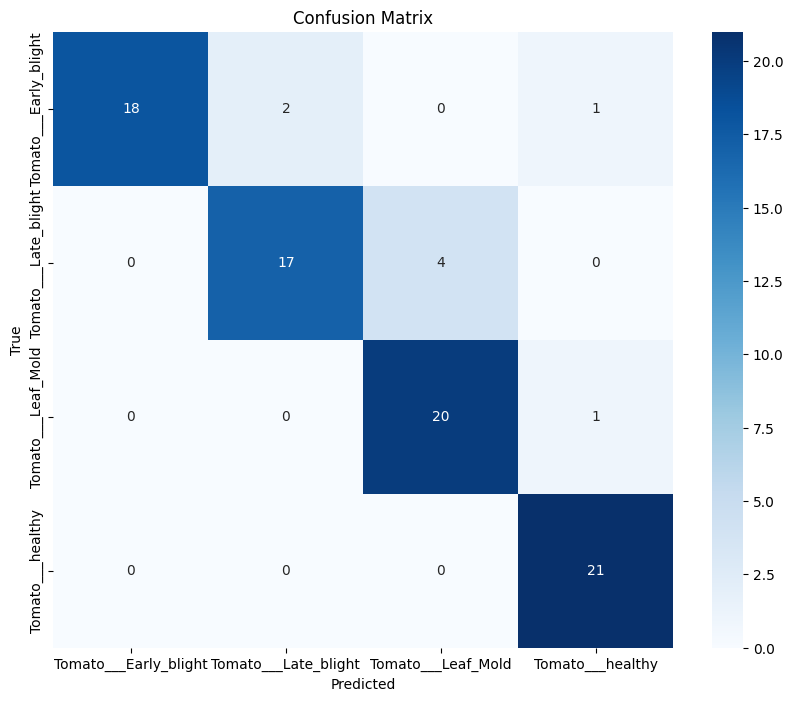

Classification Report:
                        precision    recall  f1-score   support

Tomato___Early_blight       1.00      0.86      0.92        21
 Tomato___Late_blight       0.89      0.81      0.85        21
   Tomato___Leaf_Mold       0.83      0.95      0.89        21
     Tomato___healthy       0.91      1.00      0.95        21

             accuracy                           0.90        84
            macro avg       0.91      0.90      0.90        84
         weighted avg       0.91      0.90      0.90        84

Test Accuracy: 90.48%


In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



# Buat y_true sebanyak 21 per kelas
y_true_names = []

for cls in class_names:
    y_true_names += [cls] * 21     # 21 per kelas

# Convert ke numpy
y_true_names = np.array(y_true_names)

# Pastikan panjangnya sama:
print("Panjang y_true =", len(y_true_names))
print("Panjang y_pred =", len(predicted_class_names))


# Buat confusion matrix
cm = confusion_matrix(y_true_names, predicted_class_names, labels=class_names)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



#classification report
from sklearn.metrics import classification_report
report = classification_report(y_true_names, predicted_class_names, target_names=class_names)
print("Classification Report:\n", report)

#akurasi data test
test_accuracy = accuracy_score(y_true_names, predicted_class_names) * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")



In [27]:
df = pd.DataFrame({
    'y_true': y_true_names,
    'y_pred': predicted_class_names
})

df.to_csv("test_predictions_with_assumed_ytrue.csv", index=False)

print("Saved: test_predictions_with_assumed_ytrue.csv")


Saved: test_predictions_with_assumed_ytrue.csv


In [28]:

print(len(predicted_class_names))


84
